<a href="https://colab.research.google.com/github/uhyozzy/TIL/blob/main/DeepLearning/DL2.3_%EC%A0%81%EB%8C%80%EC%A0%81%EC%8B%A0%EA%B2%BD%EB%A7%9D(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DCGAN 실습하기**
**Base**

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt


**생성자 모델 만들기**

In [ ]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

**판별자 모델 만들기**

In [15]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False  # 판별자 입장에서는 기존 데이터를 기억해놓지 않아야함

**생성자와 판별자 모델을 연결시키는 gan모델 생성**

In [16]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


**신경망을 실행시키는 함수 생성**

1/1 [==============================] - 0s 91ms/step
epoch:0  d_loss:3.3386 g_loss:0.2871
1/1 [==============================] - 0s 83ms/step
epoch:1  d_loss:0.8527 g_loss:0.1834
1/1 [==============================] - 0s 103ms/step
epoch:2  d_loss:1.0123 g_loss:0.1465
1/1 [==============================] - 0s 83ms/step
epoch:3  d_loss:1.0937 g_loss:0.1301
1/1 [==============================] - 0s 80ms/step
epoch:4  d_loss:1.1104 g_loss:0.1384
1/1 [==============================] - 0s 92ms/step
epoch:5  d_loss:1.0342 g_loss:0.1684
1/1 [==============================] - 0s 83ms/step
epoch:6  d_loss:0.9031 g_loss:0.2346
1/1 [==============================] - 0s 80ms/step
epoch:7  d_loss:0.7301 g_loss:0.3420
1/1 [==============================] - 0s 81ms/step
epoch:8  d_loss:0.5637 g_loss:0.4756
1/1 [==============================] - 0s 82ms/step
epoch:9  d_loss:0.4331 g_loss:0.6714
1/1 [==============================] - 0s 83ms/step
epoch:10  d_loss:0.3282 g_loss:0.8506
1/1 [==============

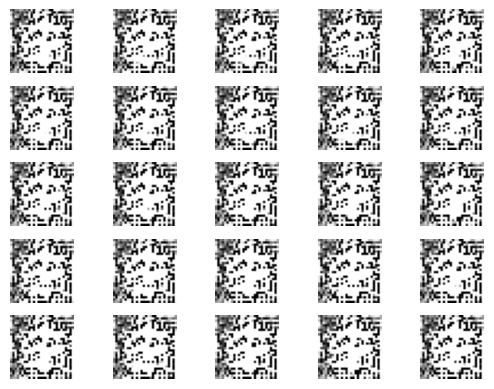

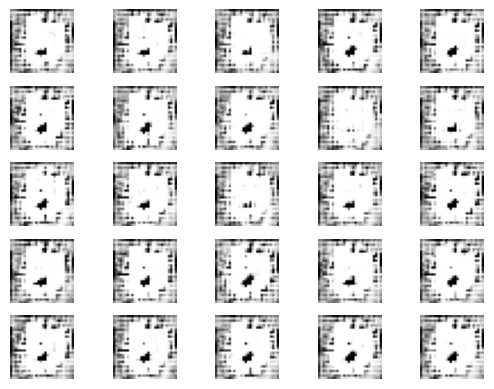

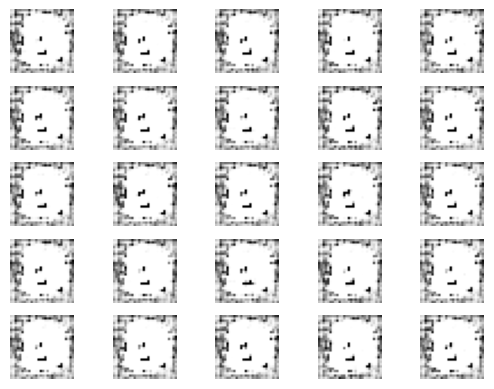

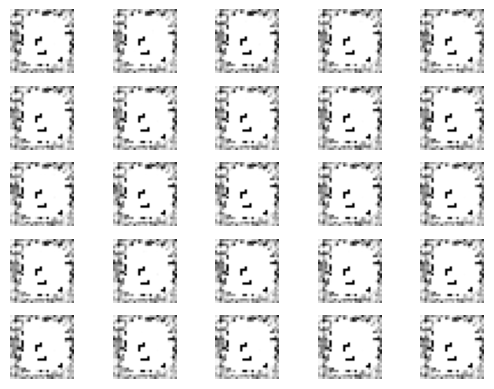

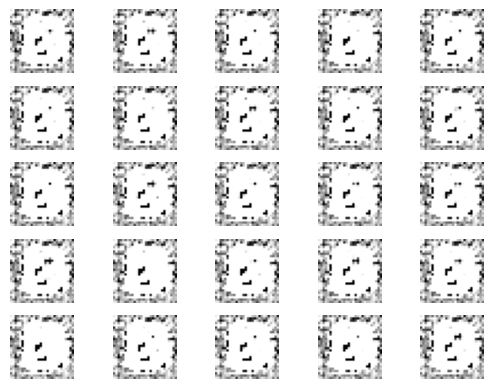

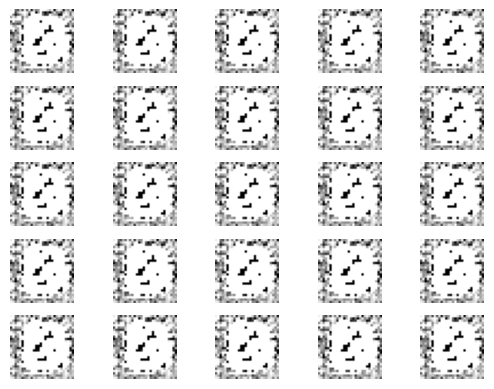

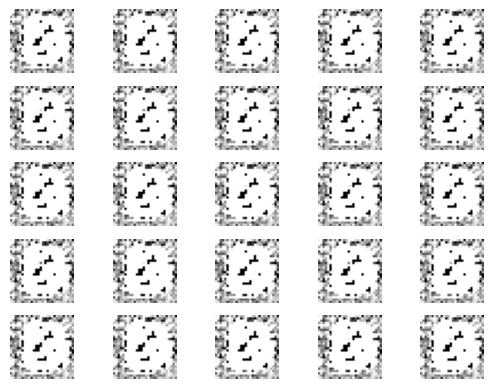

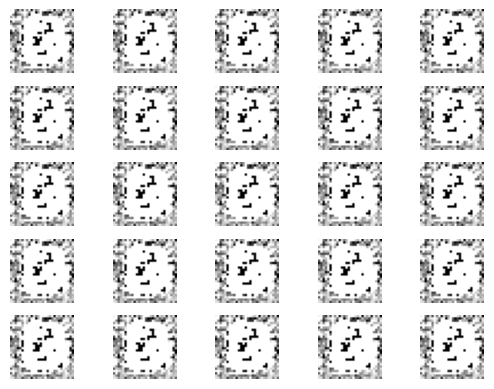

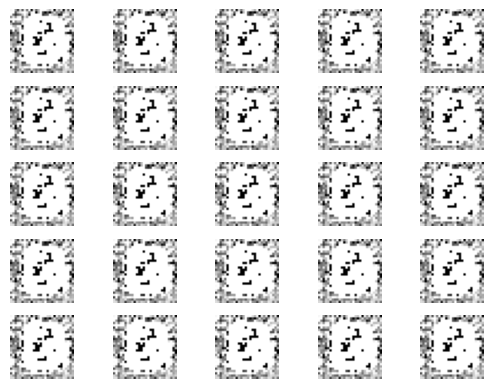

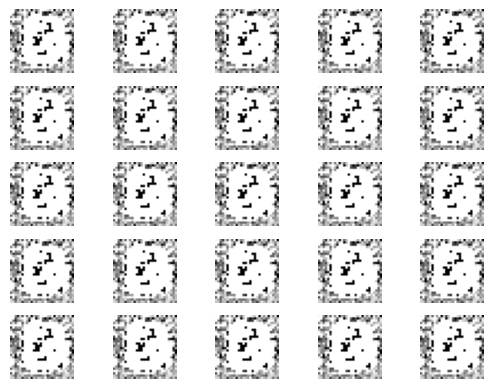

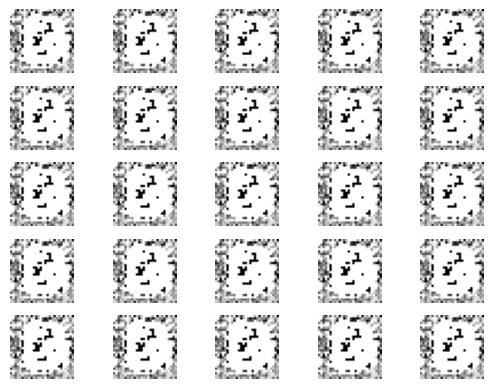

In [17]:
from numpy.lib.index_tricks import IndexExpression
def gan_train(epoch, batch_size, saving_interval):

  # MNIST데이터를 불러옴
  (X_train, _), (_,_) = mnist.load_data() #앞서 불러온 적이 있는 MNIST다시 이용
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') #단, 테스트 과정은 필요 없고 이미지만 사용할 것이기때문에 X_train만 불러옴
  X_trian = (X_train - 127.5) / 127.5
  # 픽셀 값은 0에서 255사이 값
  # 이전에 255로 나누어줄때는 이를 0~1사이의 값으로 바꾸었지만, 여기서는 127.5를 빼주고 127.5로 나누어주어서 -1에서 1사이의 값으로 바뀜
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size,1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    idx = np.random.randint(0, X_train.shape[0], batch_size) #실제 데이터를 판별자에 입력하는 부분
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    noise = np.random.normal(0, 1, (batch_size, 100)) # 가상 이미지 판별자를 입력하는 부분
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # 판별자와 생성자의 오차 계산
    g_loss = gan.train_on_batch(noise, true)

    print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

    if i % saving_interval == 0: # 이부분은 중간 과정을 이미지로 저장해주는 부분으로 만들어진 이미지는 gan_images폴더에 저장
      noise = np.random.normal(0, 1, (25, 100)) # r, c = 5, 5
      gen_imgs = generator.predict(noise)

      gen_imgs = 0.5 * gen_imgs + 0.5 # Rescale images 0 - 1

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
        fig.savefig("./gan_mnist_%d.png"%i)
gan_train(2001, 32, 200) #2000번 반복되고, 배치 사이즈는 32, 200번마다 결과가 저장되게 함

# **오토인코더(Auto Encoder)**

In [19]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import numpy as np
import matplotlib.pyplot as plt


**MNIST 데이터셋 불러오기**

In [22]:
(X_train, _), (X_test,_) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

**생성자 모델 만들기**

In [23]:
autoencoder = Sequential()

**인코딩 부분**

In [25]:
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28, 28, 1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))

autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))

autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

**디코딩 부분**

In [26]:
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())

autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())

autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())

autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

**전체 구조 확인**

In [31]:
autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 8)          

**컴파일 및 학습**

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

**학습된 결과를 출력**

313/313 [==============================] - 10s 27ms/step


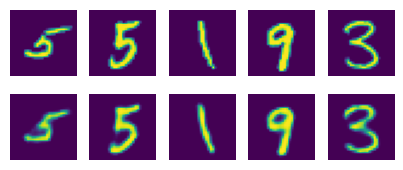

In [30]:
random_test = np.random.randint(X_test.shape[0], size=5) # 테스트할 이미지를 랜덤하게 불러옴
ae_imgs = autoencoder.predict(X_test)                    # 앞서 만든 오토인코더 모델에 집어넣음

plt.figure(figsize=(7,2))                                # 출력될 이미지의 크기를 정함

for i, image_idx in enumerate(random_test):              # 랜덤하게 뽑은 이미지를 차례로 나열
  ax = plt.subplot(2, 7, i+1)
  plt.imshow(X_test[image_idx].reshape(28, 28))          # 테스트할 이미지를 먼저 그대로 보여줌
  ax.axis('off')
  ax = plt.subplot(2, 7 ,7+i+1)
  plt.imshow(ae_imgs[image_idx].reshape(28,28))           # 오토인코딩 결과를 다음열에 출력
  ax.axis('off')
plt.show()